In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp


In [2]:
# For my computer: so it doesn't use shared GPU memory which is slower
mempool = cp.get_default_memory_pool()
mempool.set_limit(size=3.7*1024**3) # Allowing cupy 3.8 GB of GPU memory

## Model definition

In [3]:
olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
olfactory_data = np.array(olfactory_data)

In [4]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T
# olfactory_data = np.array(olfactory_data[:320,:])

In [5]:
# Model size
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (35, 153)
State count: 5355


In [6]:
# goal state
olfactory_data[17,0]

0.9988461538461538

In [7]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [8]:
# states
state_grid = []

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2))
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [10]:
# Reward function
def reward_func(s,a,sn,o):
    # return np.where(sn == (175*env_shape[1]), 1.0, 0.0)
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [11]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[10/13/2023, 00:30:32] Instantiation of MDP Model:
[10/13/2023, 00:30:32] - 5355 states
[10/13/2023, 00:30:32] - 4 actions
[10/13/2023, 00:30:32] - At most 1 reachable states per state-action pair
[10/13/2023, 00:30:32] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/13/2023, 00:30:32]     > Done in 0.000s
[10/13/2023, 00:30:32] - Generation of state grid
[10/13/2023, 00:30:32] - Generating start probabilities table
[10/13/2023, 00:30:32] - Starting computation of reachable state probabilities from transition data
[10/13/2023, 00:30:32]     > Done in 0.000s
[10/13/2023, 00:30:32] POMDP particular parameters:
[10/13/2023, 00:30:32] - 2 observations
[10/13/2023, 00:30:32] - Starting of transitional observations for reachable states table
[10/13/2023, 00:30:32]     > Done in 0.000s
[10/13/2023, 00:30:32] - Starting gener

## VI Solve

In [12]:
from src.mdp import VI_Solver

In [13]:
solver = VI_Solver(eps=1e-3)

In [14]:
solution, history = solver.solve(model, use_gpu=True)

[10/13/2023, 00:30:32] Sending Model to GPU...
[10/13/2023, 00:30:33]     > Done in 0.152s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
print(history.summary)

Summary of Value Iteration run
  - Model: 5355-state, 4-action
  - Converged in 231 iterations and 0.3160 seconds
  - Took on average 0.0014s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


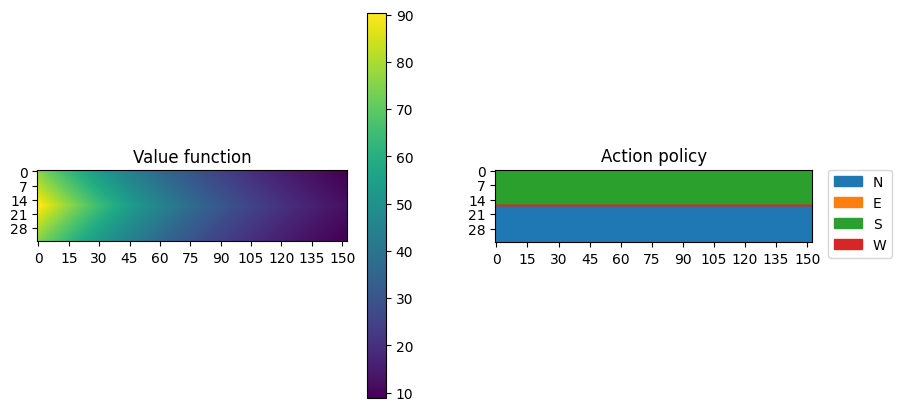

In [16]:
solution.plot()

## FSVI

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=100,
                                        horizon=300,
                                        mdp_policy=solution,
                                        # expand_prune_level=2,
                                        # history_tracking_level=2,
                                        use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
from cProfile import Profile
from pstats import SortKey, Stats

with Profile() as profile:
    fsvi_solver.solve(model=model,
                    expansions=100,
                    horizon=300,
                    mdp_policy=solution,
                    # expand_prune_level=2,
                    # history_tracking_level=2,
                    use_gpu=True)
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

         5801488 function calls (5789399 primitive calls) in 52.357 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1062770    0.215    0.000    0.215    0.000 pomdp.py:337(values)
   778070    0.211    0.000    0.286    0.000 {built-in method builtins.isinstance}
561605/561324    0.095    0.000    0.095    0.000 {built-in method builtins.len}
   540483    0.524    0.000    0.612    0.000 __init__.py:830(get_array_module)
   522493    0.396    0.000    0.580    0.000 pomdp.py:451(<genexpr>)
   522493    0.481    0.000    1.103    0.000 pomdp.py:456(<genexpr>)
   133088    0.223    0.000    0.402    0.000 numeric.py:1855(isscalar)
    71248    0.174    0.000    0.174    0.000 _internal.py:250(__init__)
    71248    0.050    0.000    0.050    0.000 _internal.py:304(data)
    71048    0.087    0.000    0.128    0.000 syncdetect.py:36(_declare_synchronize)
    71048    0.041    0.000    0.041    0.000 syncdetect.py:27(_is_allowe

In [24]:
%timeit solution.alpha_vector_array[0].tobytes()

75 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
def t1():
    x = fsvi_solution.alpha_vector_array
    dtype = np.dtype('S{:d}'.format(x.shape[1] * x.dtype.itemsize))
    in_bytes = np.frombuffer(x.tobytes(), dtype=dtype)
    t = {bi: i for bi, i in zip(in_bytes, np.arange(x.shape[0]))}

In [20]:
%timeit t1()

205 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def t2():
    t = {alpha_vector.values.tobytes(): i for alpha_vector, i in zip(fsvi_solution.alpha_vector_list, np.arange(len(fsvi_solution)))}
    a = [fsvi_solution.alpha_vector_list[i] for i in t.values()]

In [24]:
%timeit t2()

298 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 63.4330s

  - Expand function took on average 0.2504s and yielded on average 80.46 beliefs per iteration.
  - Backup function took on average 0.3839s and yielded on average value functions of size 1025.29 per iteration.


In [19]:
len(fsvi_solution)

1015

In [ ]:
fsvi_solution._uniqueness_dict.u

In [37]:
vect_array = fsvi_solution.alpha_vector_array

indices = []

for i, v in enumerate(vect_array):
    is_dom_by = cp.all(vect_array >= v, axis=1)
    if len(cp.where(is_dom_by)[0]) == 1:
        indices.append(i)

In [39]:
fsvi_solution.alpha_vector_array[indices].shape

(916, 5355)

In [19]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 68.1278s

  - Expand function took on average 0.2703s and yielded on average 82.34 beliefs per iteration.
  - Backup function took on average 0.4109s and yielded on average value functions of size 1164.13 per iteration.


In [109]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 66.3804s

  - Expand function took on average 0.2960s and yielded on average 87.36 beliefs per iteration.
  - Backup function took on average 0.3678s and yielded on average value functions of size 887.19 per iteration.


pruning exploration

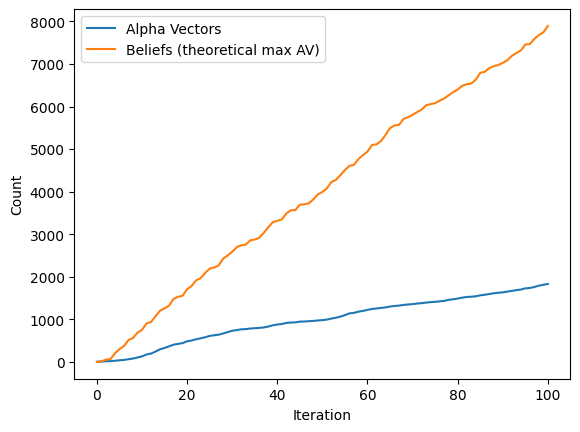

In [32]:
plt.plot(np.arange(len(hist.alpha_vector_counts)), hist.alpha_vector_counts, label='Alpha Vectors')
plt.plot(np.arange(len(hist.alpha_vector_counts)), np.cumsum(hist.beliefs_counts), label='Beliefs (theoretical max AV)')
plt.xlabel('Iteration')
plt.ylabel('Count')
plt.legend()

In [33]:
def t(vect_set):
    L = {alpha_vector.values.tobytes(): alpha_vector.values.tobytes() for alpha_vector in vect_set}
    # pruned_alpha_set = ValueFunction(model, list(L.values()))

In [35]:
vect_set = fsvi_solution.alpha_vector_list
L = {alpha_vector.values.tobytes(): alpha_vector.values.tobytes() for alpha_vector in vect_set[:900]}
L2 = {alpha_vector.values.tobytes(): alpha_vector.values.tobytes() for alpha_vector in vect_set[900:]}


In [36]:
L + L2

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [34]:
%timeit t(fsvi_solution.alpha_vector_list)

96.6 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
len(fsvi_solution)

1832

In [26]:
cp.unique(fsvi_solution.alpha_vector_array, axis=0)

NotImplementedError: axis option is not supported yet.

In [25]:
%timeit t(fsvi_solution.alpha_vector_list[:1350])

107 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit t(fsvi_solution.alpha_vector_list[:900])

73.6 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit t(fsvi_solution.alpha_vector_list[:450])

36.2 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Back step 3 exploration

In [57]:
b = Belief(fsvi_solution.model)
b_set = fsvi_solver.MDPExplore(fsvi_solution.model, b, b.random_state(), solution,0,1000)

In [59]:
len(b_set)

103

In [63]:
value_function = fsvi_solution
belief_set = b_set
gamma = 0.99

xp = np if not gpu_support else cp.get_array_module(value_function.alpha_vector_array)

# Step 1
vector_array = value_function.alpha_vector_array
vectors_array_reachable_states = vector_array[xp.arange(vector_array.shape[0])[:,None,None,None], model.reachable_states[None,:,:,:]]

gamma_a_o_t = gamma * xp.einsum('saor,vsar->aovs', model.reachable_transitional_observation_table, vectors_array_reachable_states)

# Step 2
belief_array = belief_set.belief_array
best_alpha_ind = xp.argmax(xp.tensordot(belief_array, gamma_a_o_t, (1,3)), axis=3) # bao

best_alphas_per_o = gamma_a_o_t[model.actions[None,:,None,None], model.observations[None,None,:,None], best_alpha_ind[:,:,:,None], model.states[None,None,None,:]]

alpha_a = model.expected_rewards_table.T + xp.sum(best_alphas_per_o, axis=2)

# # Step 3 # TODO potential improvement could be done here?
# alpha_vectors = xp.zeros(belief_array.shape)
# best_actions = []
# for i, b in enumerate(belief_array):
#     best_ind = int(xp.argmax(xp.dot(alpha_a[i,:,:], b)))
#     alpha_vectors[i,:] = alpha_a[i, best_ind,:]
#     best_actions.append(best_ind)

In [87]:
best_alpha_ind.shape

(103, 4, 2)

In [65]:
alpha_a.shape

(103, 4, 5355)

In [66]:
belief_array.shape

(103, 5355)

In [69]:
cp.dot(alpha_a, belief_array.T).shape

(103, 4, 103)

In [102]:
best_actions = xp.argmax(xp.einsum('bas,bs->ba', alpha_a, belief_array), axis=1)
best_alphas = cp.take_along_axis(alpha_a, best_actions[:,None,None],axis=1)[:,0,:]

In [103]:
alpha_vectors = xp.zeros(belief_array.shape)
best_actions = []
for i, b in enumerate(belief_array):
    best_ind = int(xp.argmax(xp.dot(alpha_a[i,:,:], b)))
    alpha_vectors[i,:] = alpha_a[i, best_ind,:]
    best_actions.append(best_ind)

In [105]:
def t():
    best_actions = xp.argmax(xp.einsum('bas,bs->ba', alpha_a, belief_array), axis=1)
    best_alphas = cp.take_along_axis(alpha_a, best_actions[:,None,None],axis=1)[:,0,:]

In [106]:
%timeit t()

709 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [107]:
def t2():
    alpha_vectors = xp.zeros(belief_array.shape)
    best_actions = []
    for i, b in enumerate(belief_array):
        best_ind = int(xp.argmax(xp.dot(alpha_a[i,:,:], b)))
        alpha_vectors[i,:] = alpha_a[i, best_ind,:]
        best_actions.append(best_ind)

In [108]:
%timeit t2()

26.2 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
np.argwhere(alpha_vectors != best_alphas)

array([], shape=(0, 2), dtype=int64)

Exploration of Pruning level 2

In [53]:
cp.shares_memory(fsvi_solution.alpha_vector_array, fsvi_solution.alpha_vector_array[mask])

False

In [55]:
cp.shares_memory(fsvi_solution._vector_list[0].values, cp.vstack([v.values for v in fsvi_solution._vector_list]))

False

In [50]:
mask = np.zeros(len(fsvi_solution),dtype=bool)
mask[10] = True

In [52]:
mask[10]

True

In [36]:
vf = hist.value_functions[-1]

In [38]:
np.shares_memory(vf.alpha_vector_array,
vf.alpha_vector_list[10].values)

True

Back time improvement

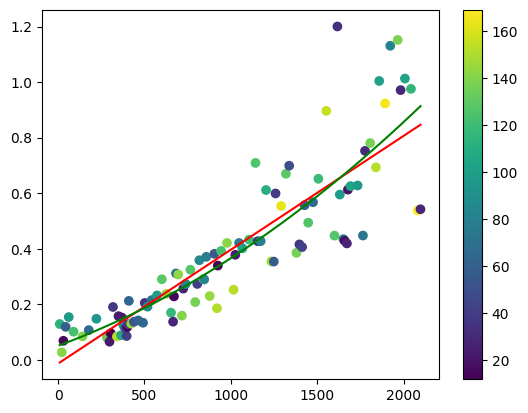

In [21]:
# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, c='red')

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

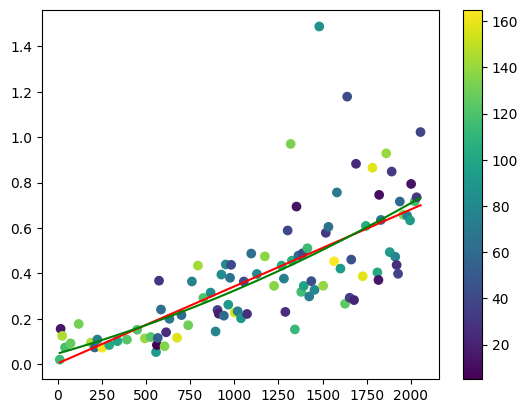

In [21]:
# With improved 3rd step

# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, c='red')

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

In [22]:
b

0.0033747248701297976

In [24]:
1/a

2947.8524052577136

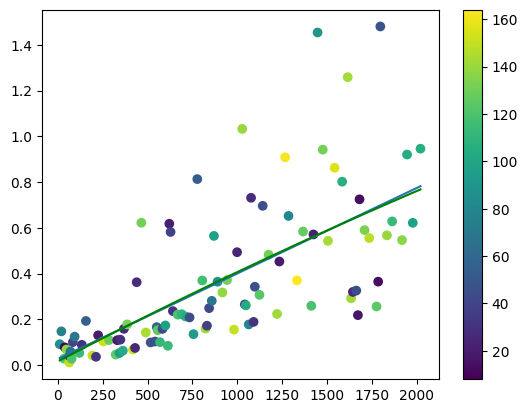

In [34]:
# Backup runtime per alpha vector count
x = np.array(hist.alpha_vector_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.beliefs_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1, c='red')
plt.plot(x, a*x+b)

fit = np.poly1d(np.polyfit(x, y, 2))
plt.plot(x, fit(x), c='green')

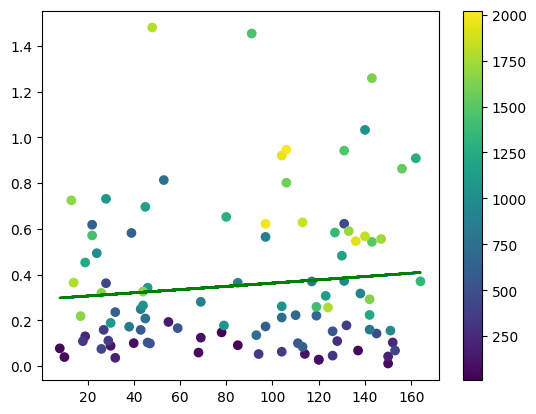

In [35]:
# Backup runtime based on belief set size
x = np.array(hist.beliefs_counts[1:-1]) # np.array(hist.beliefs_counts[1:-1])
y = np.array(hist.backup_times[1:])

cs = np.array(hist.alpha_vector_counts[1:-1])
# cs = cs / np.max(cs)

plt.scatter(x, y, c=cs)
plt.colorbar()

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

fit = np.poly1d(np.polyfit(x, y, 2)) 
plt.plot(x, fit(x), c='green')

In [31]:
np.max(cs)

164

In [19]:
import cupy as cp

In [20]:
vect_array = fsvi_solution.to_cpu().alpha_vector_array

In [21]:
vect_array.shape

(1771, 5355)

In [23]:
v = vect_array[0]

(1, 5355)

In [ ]:
is_dom = np.all(vect_array[:,None,:] <= v[None,:], axis=2)

In [23]:
from tqdm.notebook import tqdm

In [39]:
vect_array <= vect_array[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [24]:
# vect_array = fsvi_solution.to_cpu().alpha_vector_array
vect_array = fsvi_solution.alpha_vector_array

indices = []

for i, v in tqdm(enumerate(vect_array)):
    is_dom_by = cp.all(vect_array >= v, axis=1)
    if len(cp.where(is_dom_by)[0]) == 1:
        indices.append(i)

0it [00:00, ?it/s]

In [42]:
# vect_array = fsvi_solution.to_cpu().alpha_vector_array
vect_array = cp.flip(fsvi_solution.alpha_vector_array, axis=0)

indices = []

for i, v in tqdm(enumerate(vect_array)):
    is_dom_by = cp.all(vect_array[(i+1):] >= v, axis=1)
    # print(is_dom_by.shape)
    # np.where(is_dom_by)
    # print(np.where(is_dom_by)[0])
    if len(cp.where(is_dom_by)[0]) == 0:
        indices.append(i)

    # if i > 10:
    #     break
    # break

0it [00:00, ?it/s]

In [43]:
len(indices)

1767

In [44]:
def dom_ind(vect_array):
    indices = []

    for i, v in tqdm(enumerate(vect_array)):
        is_dom_by = cp.all(vect_array >= v, axis=1)
        if len(cp.where(is_dom_by)[0]) == 1:
            indices.append(i)

    return indices

In [45]:
inds = dom_ind(vect_array)

0it [00:00, ?it/s]

In [46]:
len(inds)

1122

In [50]:
from numba import njit

In [55]:

def dom_ind(vect_array):
    indices = []

    for i, v in tqdm(enumerate(vect_array)):
        is_dom_by = np.all(vect_array >= v, axis=1)
        if len(np.where(is_dom_by)[0]) == 1:
            indices.append(i)

    return indices

In [56]:
inds = dom_ind(fsvi_solution.to_cpu().alpha_vector_array)

0it [00:00, ?it/s]

In [59]:
@njit
def dom_ind(vect_array):
    indices = []

    for i, v in enumerate(vect_array):
        is_dom_by = np.all(vect_array >= v, axis=1)
        if len(np.where(is_dom_by)[0]) == 1:
            indices.append(i)

    return indices

In [61]:
inds = dom_ind(fsvi_solution.to_cpu().alpha_vector_array)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function all at 0x000001E8486B7D80>) found for signature:
 
 >>> all(array(bool, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
[1m   - Of which 2 did not match due to:
   Overload in function 'np_all': File: numba\np\arraymath.py: Line 801.
     With argument(s): '(array(bool, 2d, C), axis=int64)':[0m
[1m    Rejected as the implementation raised a specific error:
      TypingError: [1mgot an unexpected keyword argument 'axis'[0m[0m
  raised from c:\Users\arnau\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\typing\templates.py:784
[0m
[0m[1mDuring: resolving callee type: Function(<function all at 0x000001E8486B7D80>)[0m
[0m[1mDuring: typing of call at C:\Users\arnau\AppData\Local\Temp\ipykernel_23460\3382934699.py (6)
[0m
[1m
File "C:\Users\arnau\AppData\Local\Temp\ipykernel_23460\3382934699.py", line 6:[0m
[1mdef dom_ind(vect_array):
    <source elided>
    for i, v in enumerate(vect_array):
[1m        is_dom_by = np.all(vect_array >= v, axis=1)
[0m        [1m^[0m[0m


In [30]:
t = np.arange(20).reshape((4,5))
t

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [41]:
np.flip(t, axis=0)

array([[15, 16, 17, 18, 19],
       [10, 11, 12, 13, 14],
       [ 5,  6,  7,  8,  9],
       [ 0,  1,  2,  3,  4]])

In [26]:
fsvi_solution.alpha_vector_array[:i:].shape

(1770, 5355)

In [25]:
len(indices)

1122

In [15]:
from numba import njit

In [59]:
is_dominated = np.all(vect_array[:,None,:] <= vect_array, axis=2)

KeyboardInterrupt: 

In [38]:
np.where(~np.any(is_dominated, axis=1))

(array([], dtype=int64),)

In [42]:
p_baseline = fsvi_solution.prune(level=2)

In [43]:
p_baseline.alpha_vector_array.shape

(1178, 5355)

In [56]:
combined_matrix.shape

(1761, 5355)

In [55]:
differences = combined_matrix[:, np.newaxis, :] - combined_matrix
differences = differences.reshape(-1, combined_matrix.shape[1])

# Calculate the maximum differences along rows
max_differences = np.max(differences, axis=1).reshape(-1, combined_matrix.shape[0])

# Create a mask for non-dominated rows
is_dominated = max_differences > 0

# Extract the non-dominated rows
non_dominated_rows = combined_matrix[~np.any(is_dominated, axis=1)]



MemoryError: Unable to allocate 124. GiB for an array with shape (1761, 1761, 5355) and data type float64

In [44]:
from deap import base, tools

In [50]:
from deap import creator

In [47]:
combined_matrix = vect_array

In [ ]:
base.Toolbox()

In [54]:
toolbox

In [53]:
# Initialize DEAP tools
# creator.create("FitnessMulti", base.Fitness, weights=(1.0,) * combined_matrix.shape[0])
# creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, combined_matrix)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Perform non-dominated sorting
pop = toolbox.population(n=1761)
nondominated_fronts = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]

# Extract the non-dominated rows
non_dominated_rows = [combined_matrix[i] for i in nondominated_fronts]


TypeError: 'numpy.ndarray' object is not callable

In [30]:
(vect_array)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [5.52430851, 5.52430851, 5.52430851, ..., 0.        , 0.        ,
        0.        ],
       [5.52430851, 5.52430851, 5.52430851, ..., 0.        , 0.        ,
        0.        ],
       [5.52430851, 5.52430851, 5.52430851, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 97.6274s

  - Expand function took on average 0.5387s and yielded on average 80.39 beliefs per iteration.
  - Backup function took on average 0.4375s and yielded on average value functions of size 964.96 per iteration.


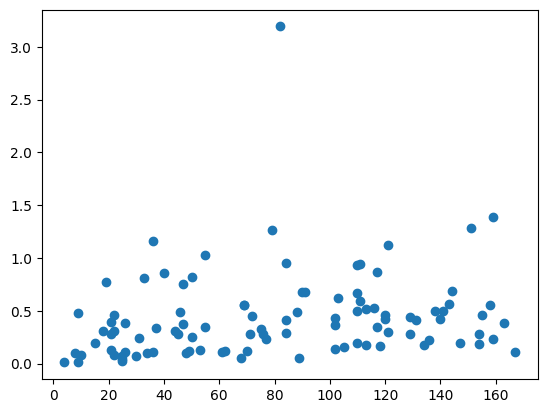

In [21]:
plt.scatter(hist.beliefs_counts[1:], hist.backup_times)

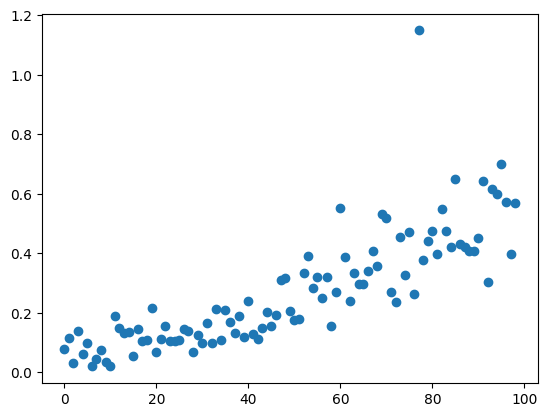

In [26]:
plt.scatter(np.arange(len(hist.backup_times[1:])), hist.backup_times[1:])

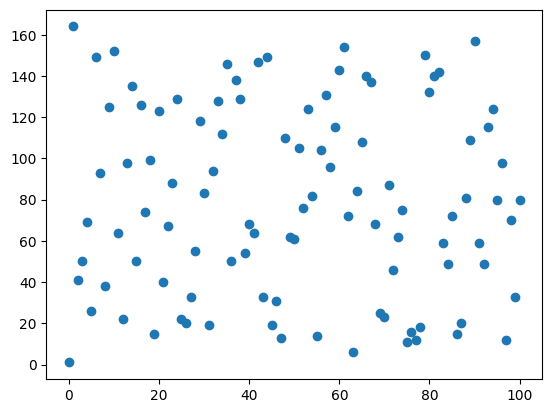

In [25]:
plt.scatter(np.arange(len(hist.beliefs_counts)), hist.beliefs_counts, )

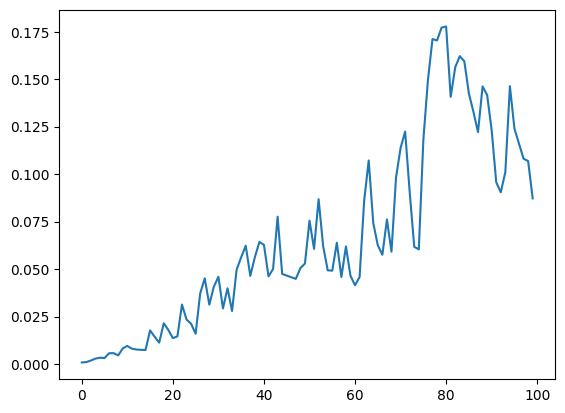

In [28]:
plt.plot(np.arange(len(hist.value_function_changes)), hist.value_function_changes)

## FSVI with mdp solution as initial value function

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model, 100, 300, mdp_policy=solution, initial_value_function=solution, use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

Converged early...


## Simulation

[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


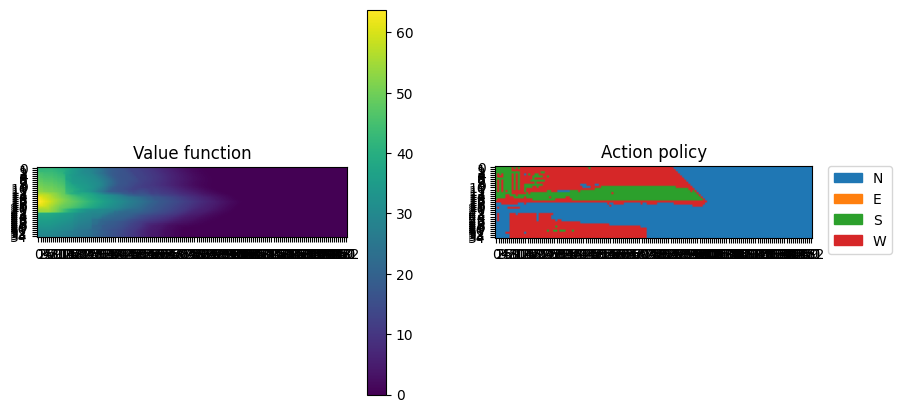

In [31]:
fsvi_solution.plot()

In [19]:
a = Agent(model)
a.value_function = fsvi_solution.to_cpu()

In [20]:
sim_hist = a.simulate(start_state=(153*13)-1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.729039
	- Steps: 176
	- Total rewards: 1.0
	- End state: s_17_0


In [33]:
sim_hist.actions[19]

3

In [32]:
sim_hist.observations[19]

1

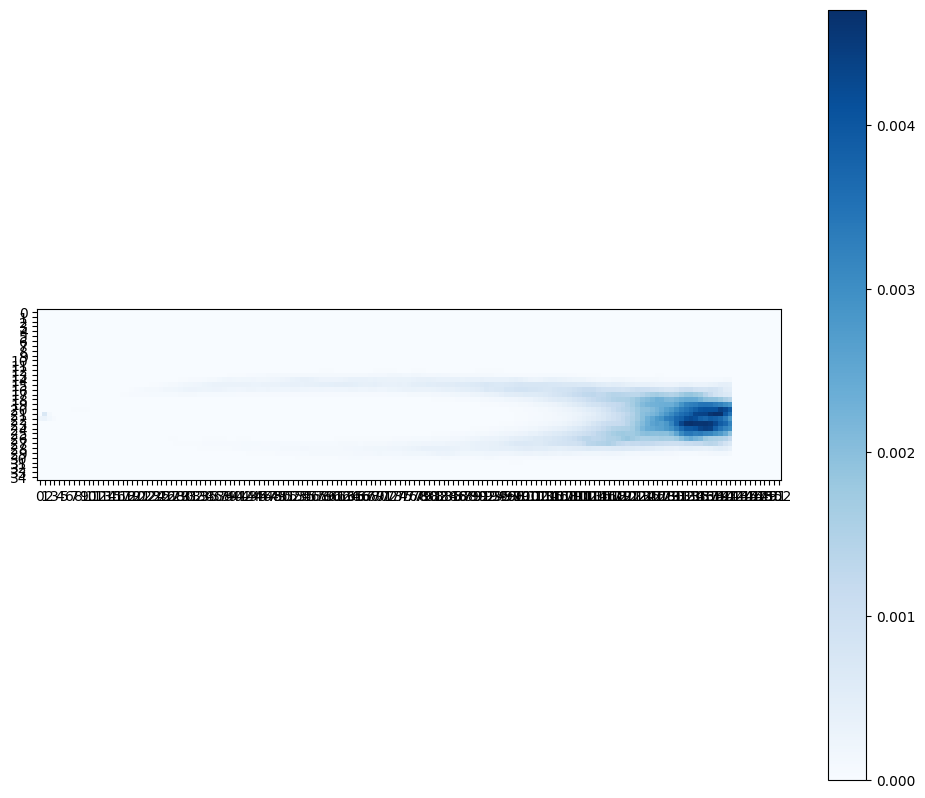

In [31]:
sim_hist.beliefs[19].plot(size=10)

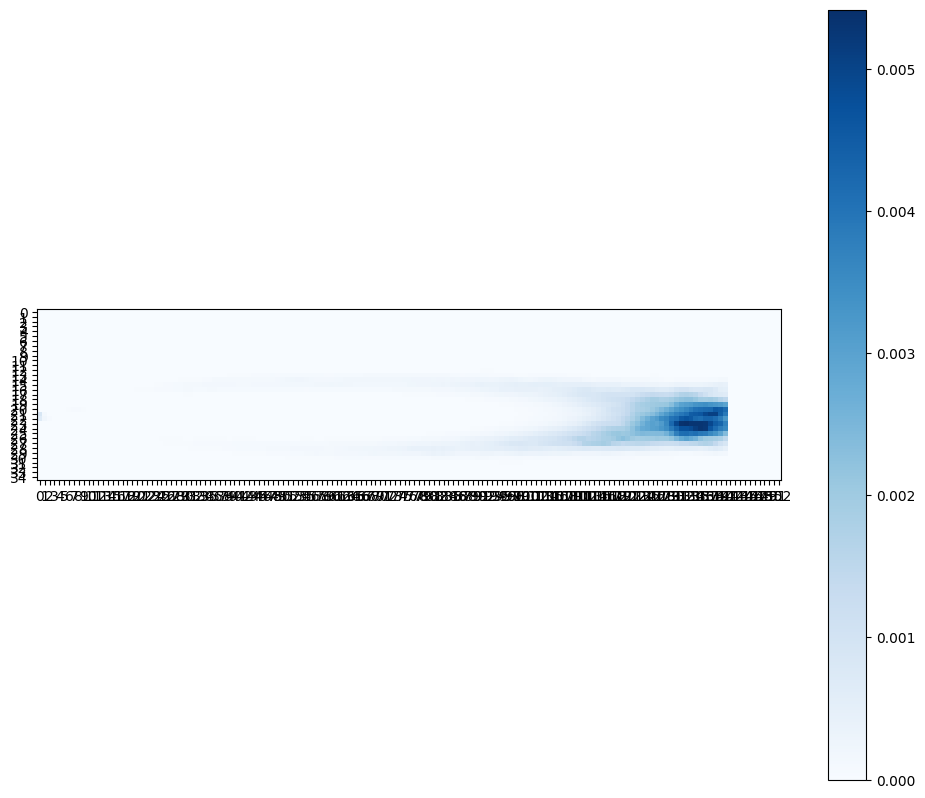

In [30]:
sim_hist.beliefs[20].plot(size=10)

In [21]:
sim_hist.save_simulation_video(fps=10)

Video saved at 'Sim Videos/s5355-a4-20231009_014051.mp4'...
